In [1]:
import glob
import pandas as pd
from scipy import stats
import numpy as np
import itertools

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
file_list = glob.glob('../output/*.csv')

n = len(file_list) # Número de sementes: 10 (Número de arquivos lido)
dfs = [pd.read_csv(file) for file in file_list]

df = pd.concat(dfs)
df = df[df['vType'] == 'emergency_emergency']
df.head(2)

,id,depart,departLane,departPos,departPosLat,departSpeed,departDelay,arrival,arrivalLane,arrivalPos,...,vType,speedFactor,vaporized,seed,ALGORITHM,DELAY_TO_DISPATCH_EMERGENCY_VEHICLE,CAR_FOLLOW_MODEL,TIME_TO_BLOCK_CREATE_ACCIDENTS,SAVEDS,UNSAVEDS
1793,veh_emergency_360.0,419.0,A3B3_0,6.6,0.0,0.0,29.0,778.0,E2D2_1,272.8,...,emergency_emergency,1.0,NaN,999,default,30.0,Krauss,50.0,6,3
2130,veh_emergency_490.0,520.0,A3B3_2,6.6,0.0,0.0,0.0,890.0,E2D2_0,272.8,...,emergency_emergency,1.0,NaN,999,default,30.0,Krauss,50.0,6,3


In [3]:
lista_index = ['ALGORITHM', 'TIME_TO_BLOCK_CREATE_ACCIDENTS', 'DELAY_TO_DISPATCH_EMERGENCY_VEHICLE','CAR_FOLLOW_MODEL']
var_resposta = list(set(df.columns) - set(lista_index+['id', 'depart', 'departLane', 'departPos', 'departPosLat',
                                                       'departSpeed', 'departDelay', 'arrival', 'arrivalLane', 'arrivalPos', 'arrivalPosLat',
                                                       'arrivalSpeed','devices','vaporized','vType', 'seed', 'sppedFactor'
                                                       ]))
var_resposta

['speedFactor',
 'rerouteNo',
 'SAVEDS',
 'timeLoss',
 'stopTime',
 'routeLength',
 'UNSAVEDS',
 'waitingCount',
 'waitingTime',
 'duration']

In [4]:
grouped = df.drop(columns=['id', 'depart', 'departLane', 'departPos', 'departPosLat',
                                                       'departSpeed', 'departDelay', 'arrival', 'arrivalLane', 'arrivalPos', 'arrivalPosLat',
                                                       'arrivalSpeed','devices','vaporized','vType',]).groupby(lista_index).agg(['mean','std']).reset_index()
#Cirando coluna ID para o gráfico de barra com intervalo de confiança
grouped['id'] = grouped[lista_index].apply(lambda x: '-'.join(x.astype(str)), axis=1)
grouped.sort_values(by=lista_index,ascending=[True, True,True,True], inplace=True)

grouped.head(2)

ALGORITHM TIME_TO_BLOCK_CREATE_ACCIDENTS  \
                                             
0   default                           50.0   
1   default                           50.0   

  DELAY_TO_DISPATCH_EMERGENCY_VEHICLE CAR_FOLLOW_MODEL     duration  \
                                                               mean   
0                                30.0             EIDM  1012.273973   
1                                30.0           Krauss   737.571429   

               routeLength             waitingTime              ... rerouteNo  \
          std         mean         std        mean         std  ...       std   
0  625.556758  2592.033425  524.390983  588.726027  585.943666  ...       0.0   
1  308.327427  2725.914286  693.917299  280.071429  235.738925  ...       0.0   

  speedFactor             seed                SAVEDS            UNSAVEDS  \
         mean  std        mean         std      mean       std      mean   
0         1.0  0.0  885.260274  715.918408  5.958904  2.750951  3.178082   
1         1.0  0.0  588.857143  491.469830  5.571429  0.513553  2.571429   

                                   id  
        std                            
0  2.329416    default-50.0-30.0-EIDM  
1  0.513553  default-50.0-30.0-Krauss  

[2 rows x 27 columns]

In [5]:
def calc_interval(grouped,var_resposta,n = 10,column_x = 'id', rotation = 0, z = stats.norm.ppf(0.975)):
    for var in var_resposta:
        #Calculo do erro médio para o intervalo de confiança
        grouped[(var, 'mean_error')] = z * (grouped[(var, 'std')] / np.sqrt(n))

In [6]:
calc_interval(grouped=grouped, var_resposta=var_resposta)

In [7]:
num_factors = len(lista_index)
factor_names = lista_index
factor_levels_real = {factor:list(grouped[factor].unique()) for factor in factor_names}
num_factors, factor_levels_real

(4,
 {'ALGORITHM': ['default', 'proposto'],
  'TIME_TO_BLOCK_CREATE_ACCIDENTS': [50.0, 100.0],
  'DELAY_TO_DISPATCH_EMERGENCY_VEHICLE': [30.0, 120.0],
  'CAR_FOLLOW_MODEL': ['EIDM', 'Krauss']})

In [8]:
num_response_vars = len(var_resposta)
response_vars_names = var_resposta
num_response_vars, response_vars_names

(10,
 ['speedFactor',
  'rerouteNo',
  'SAVEDS',
  'timeLoss',
  'stopTime',
  'routeLength',
  'UNSAVEDS',
  'waitingCount',
  'waitingTime',
  'duration'])

In [9]:
# Calculating the total number of experiments
total_experiments = 2 ** num_factors
# total_experiments

In [10]:
# Preparing the DataFrame
level_combinations = list(itertools.product([-1, 1], repeat=num_factors))
experiment_design_df = pd.DataFrame(level_combinations, columns=factor_names)
experiment_design_df.insert(0, 'Exp', range(1, len(experiment_design_df) + 1))
# level_combinations, experiment_design_df

In [11]:
for var_name in response_vars_names:
    experiment_design_df[var_name] = grouped[var_name]['mean']
    experiment_design_df[var_name+'_err'] = grouped[var_name]['mean_error']
# experiment_design_df

In [12]:
# Generating interactions between factors
interaction_columns = []
for combo_length in range(2, num_factors + 1):
    for combo in itertools.combinations(factor_names, combo_length):
        interaction_name = ':'.join(combo)
        experiment_design_df[interaction_name] = np.prod(experiment_design_df[list(combo)], axis=1)
        interaction_columns.append(interaction_name)

In [13]:
# Adjusting real levels in the real experiment settings
experiment_settings_real_df = experiment_design_df.copy()
for factor_name in factor_names:
    experiment_settings_real_df[factor_name] = experiment_settings_real_df[factor_name].map({-1: factor_levels_real[factor_name][0], 1: factor_levels_real[factor_name][1]})

In [14]:
# Function to calculate the effects and SS
def calculate_effects_SS_dynamic(df, response_var_names):
    results = {}
    for response_var_name in response_var_names:
        n = len(df)
        response_values = df[response_var_name].values
        factor_columns = [col for col in df.columns if col not in ['Exp'] + response_var_names]
        effects = {}
        SS = {}

        for factor in factor_columns:
            factor_values = df[factor].values
            effect = np.sum(factor_values * response_values) / n
            effects[factor] = effect
            SS[factor] = n * effect ** 2

        SST = np.sum((response_values - np.mean(response_values)) ** 2)
        results[response_var_name] = (effects, SS, SST)
    return results

# Function to print formatted results
def print_formatted_results(results):
    for response_var_name, (effects, SS, SST) in results.items():
        print(f"\n{response_var_name} - Effects of Factors and Interactions:")
        for name, effect in effects.items():
            print(f"  {name}: {effect:.4f}")
        print(f"\n{response_var_name} - Sum of Squares (SS) for each Factor and Interaction:")
        for name, ss in SS.items():
            print(f"  {name}: {ss:.4f}")
        print(f"\n{response_var_name} - Total Sum of Squares (SST): {SST:.4f}")
        print(f"\n{response_var_name} - Percentage Influence of each Factor and Interaction:")
        for name, ss in SS.items():
            print(f"  {name}: {(ss / SST) * 100:.2f}%")

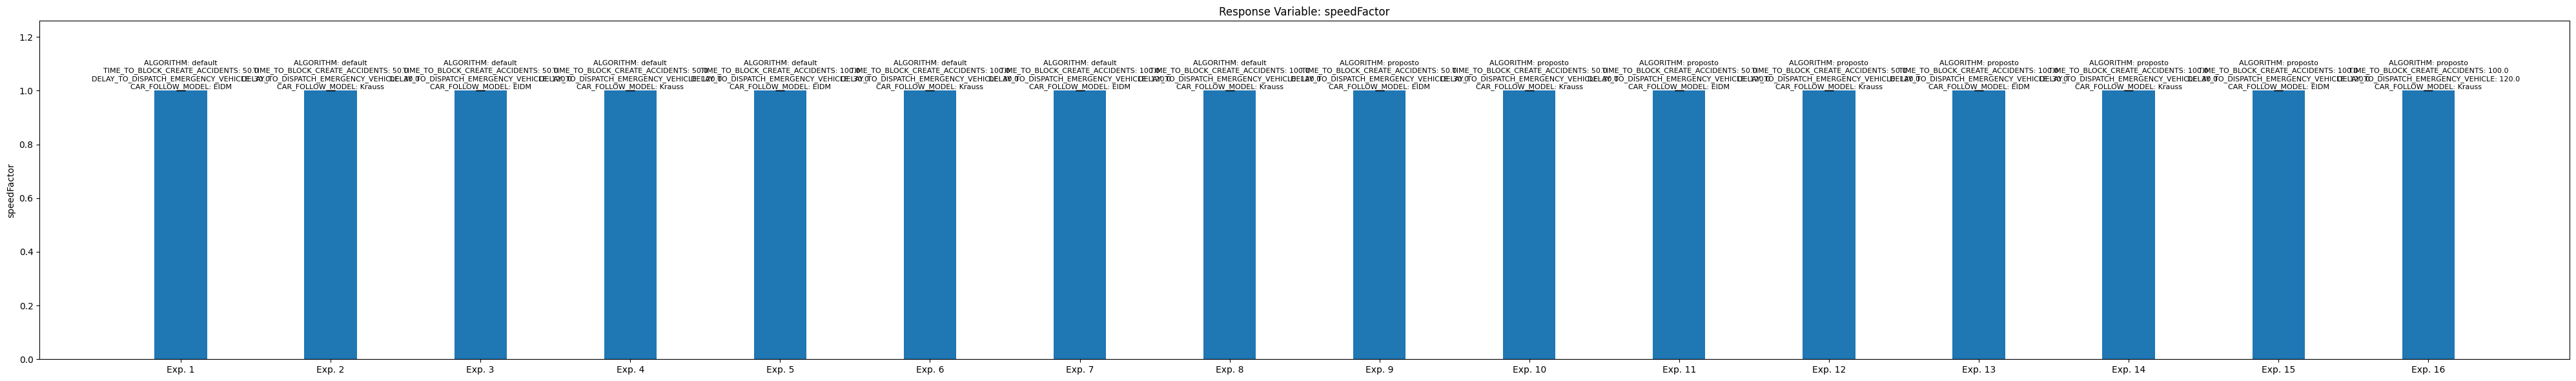

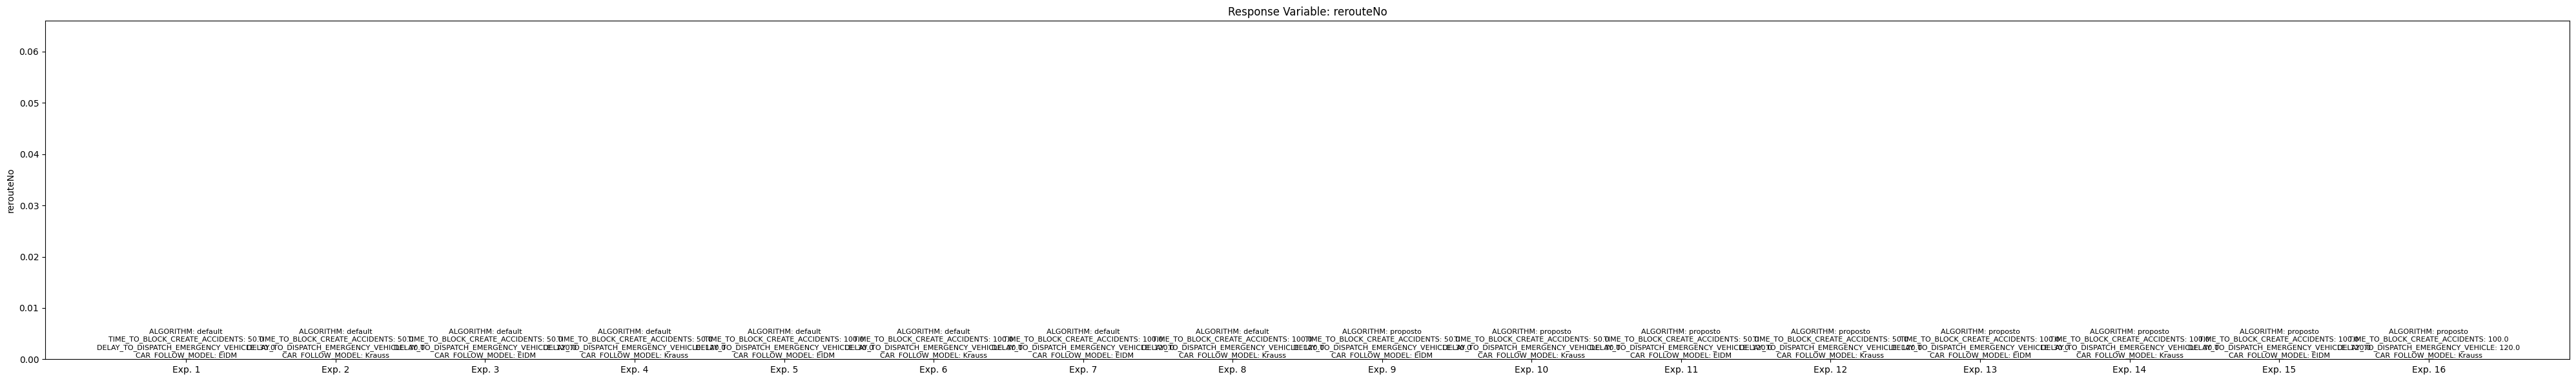

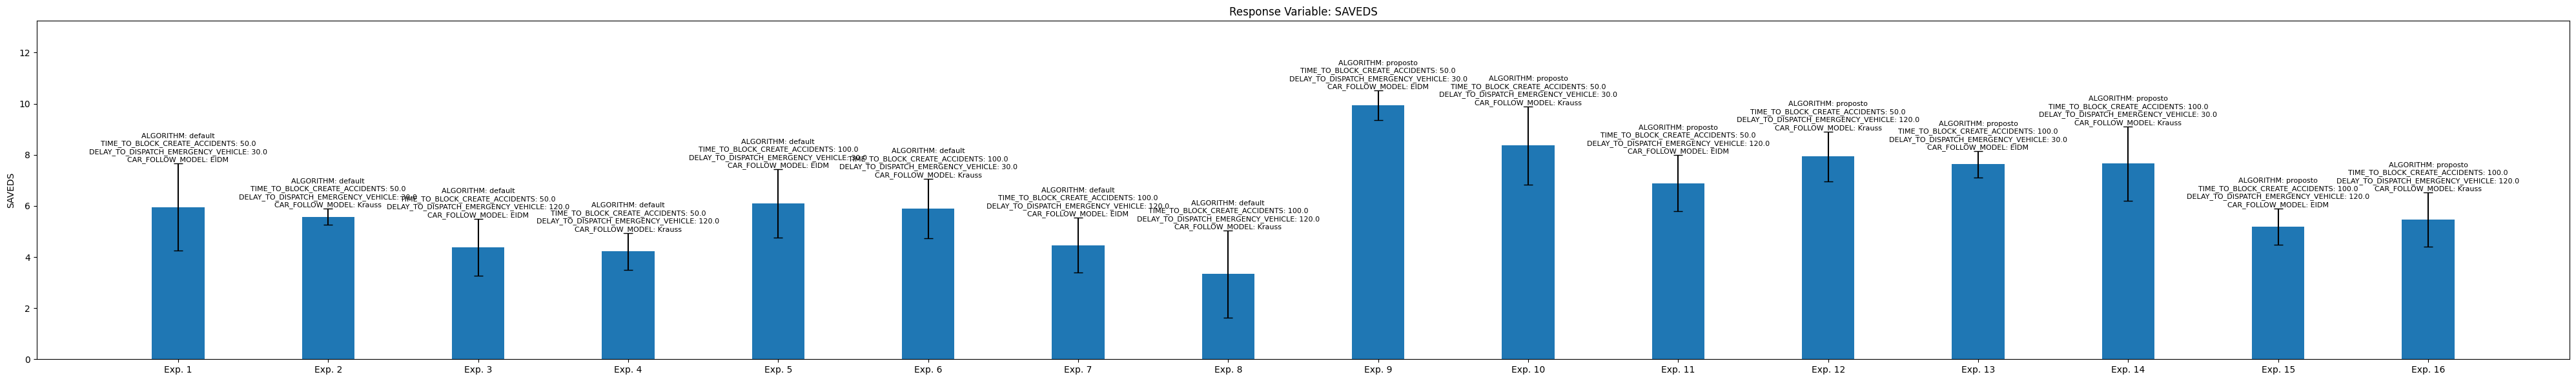

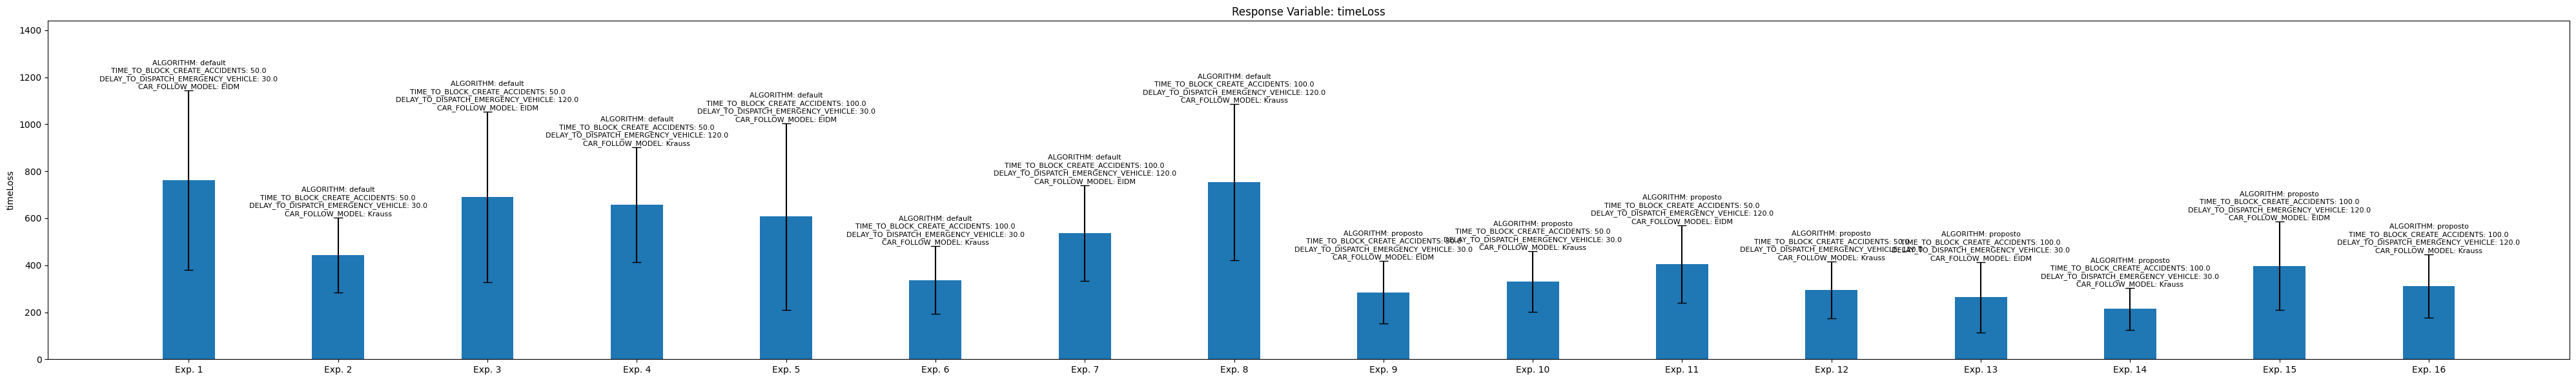

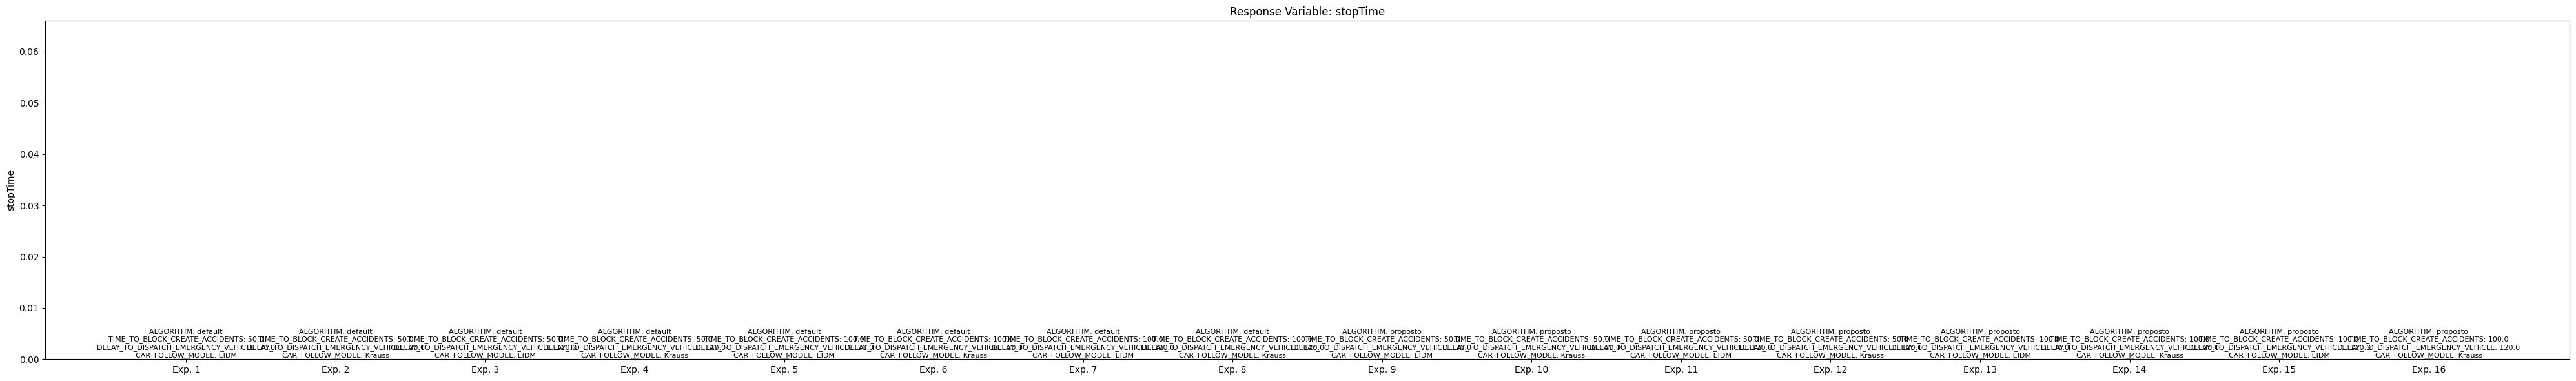

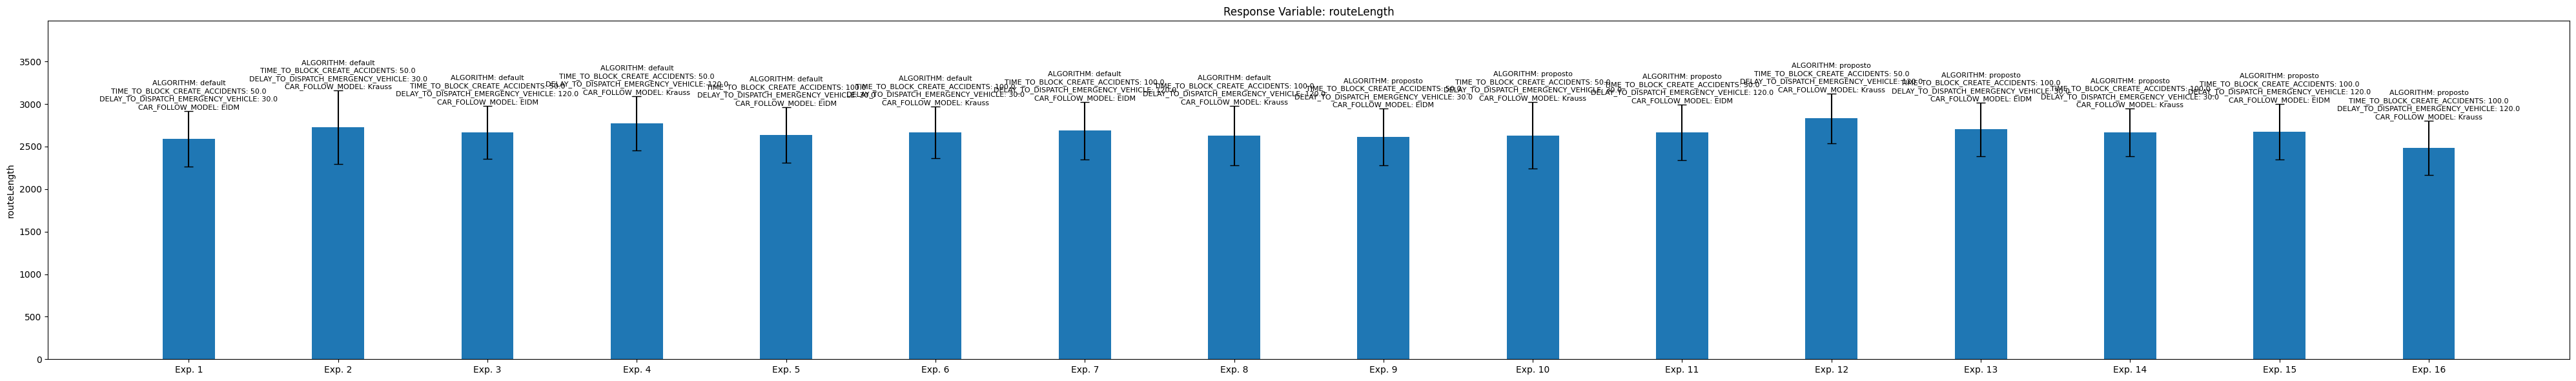

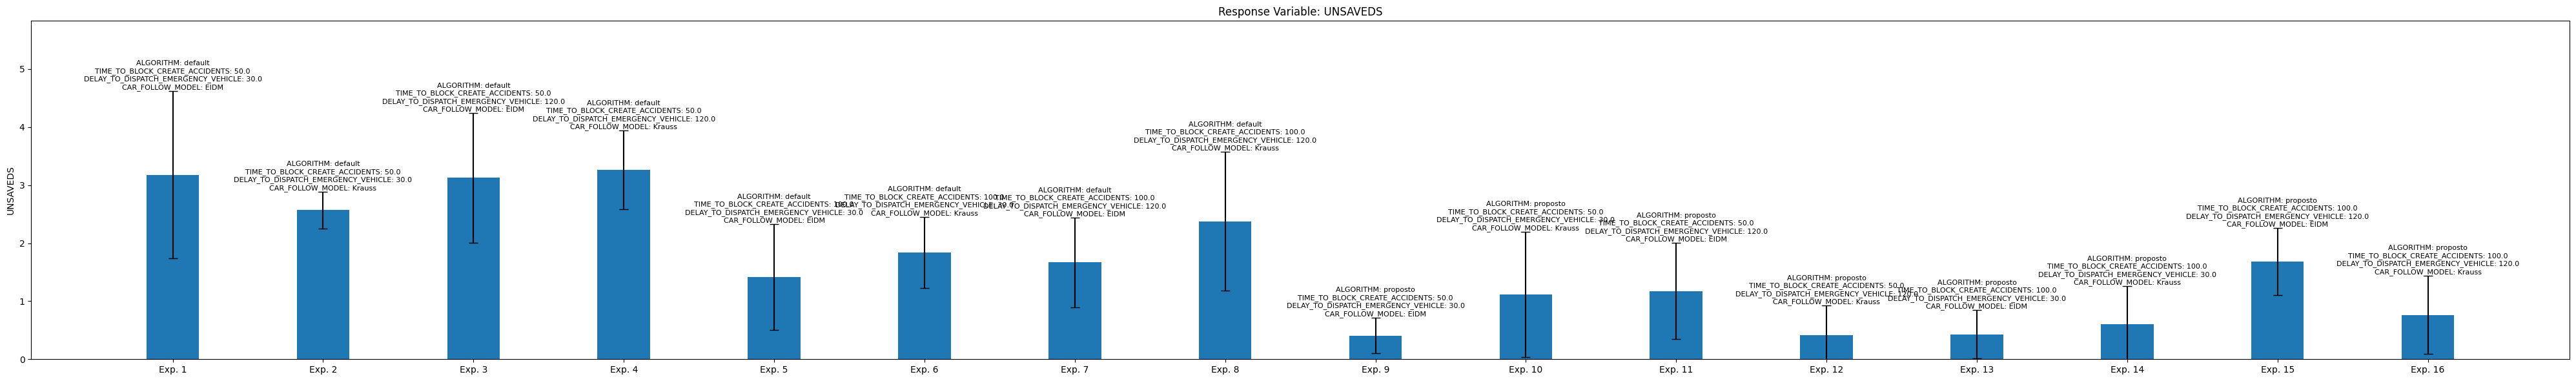

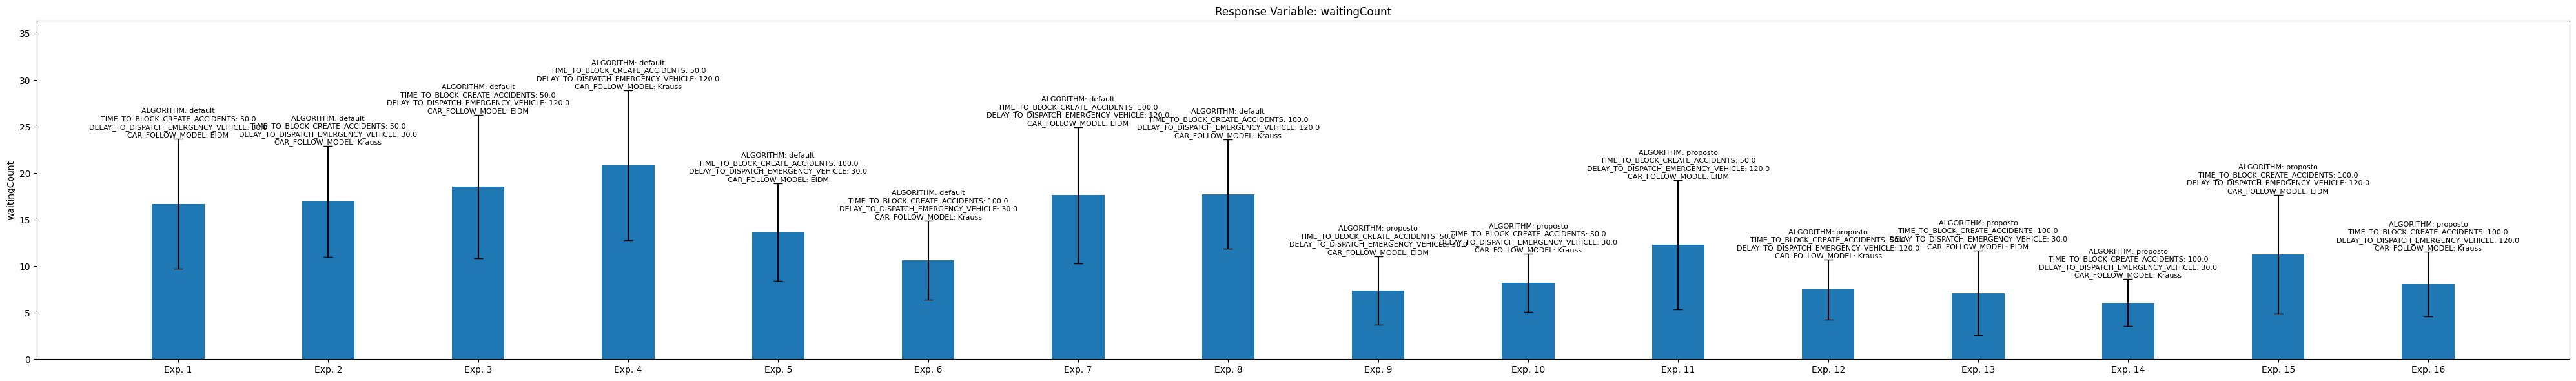

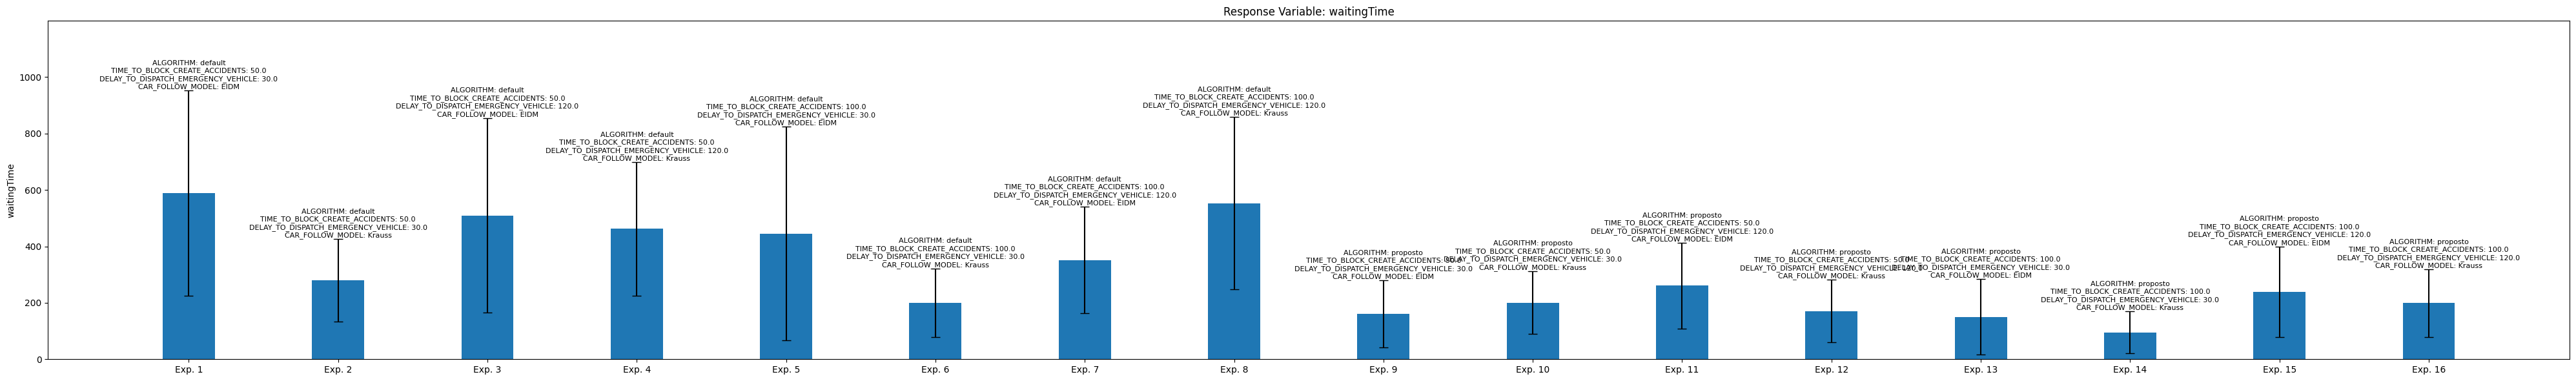

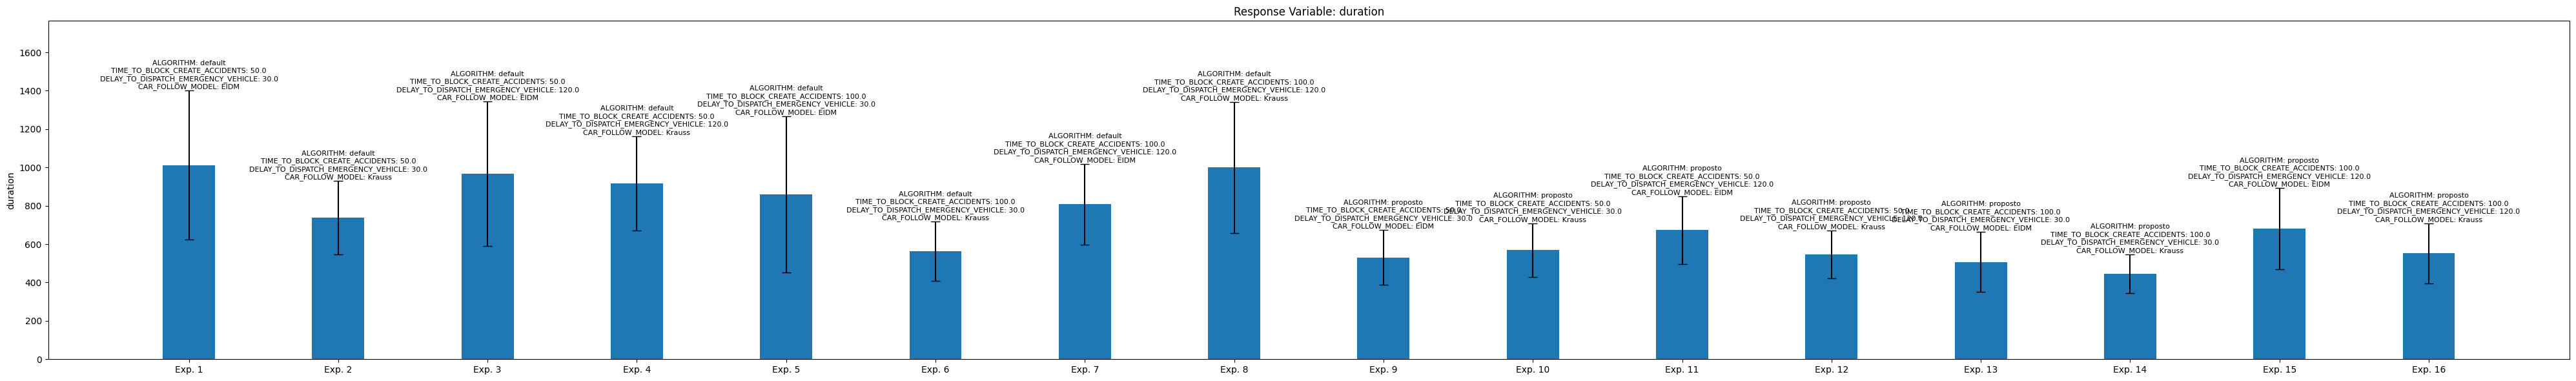

In [15]:
n_cols = 4
# Adjusting the bar width, if necessary
width = 0.35

for var_name in response_vars_names:
    # Increasing the chart height to accommodate labels
    plt.figure(figsize=(10 * n_cols, 6))  # Increasing the second value in figsize to increase the chart height
    
    n_experiments = len(experiment_settings_real_df)  # Number of experiments
    ind = np.arange(n_experiments)  # Indices for the experiments for bar positioning
    
    # Plotting the data from the real experiment settings
    bars = plt.bar(ind, experiment_settings_real_df[var_name],yerr=experiment_settings_real_df[var_name+"_err"],capsize=5,width= width, label='Experiments')
    # for i, (x_val, y_val, yerr_val) in enumerate(zip(grouped[column_x], grouped[(var, 'mean')], grouped[(var, 'mean_error')])):
    # plt.bar(x_val, y_val, yerr=yerr_val, color=colors[group_labels[i]], capsize=5)
    
    plt.title(f'Response Variable: {var_name}')  # Chart title
    plt.ylabel(var_name)  # Y-axis label
    
    # Generating labels for each bar based on factor combinations
    exp_labels = ['Exp. ' + str(exp) for exp in experiment_settings_real_df['Exp']]
    plt.xticks(ind, exp_labels)
    
    # Adding labels above bars to show factor combinations
    for bar, label in zip(bars, experiment_settings_real_df.to_dict('records')):
        height = bar.get_height()
        comb_label = '\n'.join([f"{k}: {v}" for k, v in label.items() if k in factor_names])
        height_err_plus = label[var_name+"_err"]
        plt.text(bar.get_x() + bar.get_width() / 2, height+height_err_plus, comb_label, ha='center', va='bottom', rotation=0, fontsize=8)
    
    # Adjusting the Y-axis limits to ensure labels fit without being cut off
    plt.ylim(0, plt.ylim()[1] * 1.2)  # Increases the upper limit of the Y-axis by 20%

    plt.tight_layout()
    # plt.savefig('../plot/Experiment/{}.pdf'.format(var_name), format='pdf')
    plt.savefig('../plot/Tripinfo_Emergency_Vehicle_Experiment/{}.pdf'.format(var_name), format='pdf')
    plt.show()
